## Energy PLUS PLUS - ML Demo/ Graph Generation

This notebook has code for running the Energy++ ML model using yolov5 and then structuring the obtained bounding boxes into a connectivity graph.

In order to use this notebook, please ensure that this file is inside the yolov5 repository folder which you can clone from [here](https://github.com/ultralytics/yolov5). Also, the image that needs to be segmented needs to have the name "test.png" at the moment which ofcourse can be changed but you would have to edit the code.

Also, make sure the weights/model you wish to load is placed in yolov5/runs/train/exp/(name of your weights file .pt or .pth usually).

In [40]:
# Importing necessary libraries

import cv2
import torch
from IPython.display import display
import PIL
from PIL import Image
import numpy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw, ImageFont
from tkinter import *

In [41]:
path ="test.png"
path = cv2.imread(path)

In [42]:
# Loading model with the best run so far

model = torch.hub.load('ultralytics/yolov5', 'custom', 'runs/train/exp9/weights/best.pt',)
model.conf = 0.52

Using cache found in /home/karkidai/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-30 Python-3.9.12 torch-1.12.1+cu102 CPU

Fusing layers... 
Model summary: 213 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [43]:
# Evaluating the model on a test image
model.eval()
result = model(path)

In [44]:
print(result)

image 1/1: 3508x2480 5 rooms
Speed: 127.4ms pre-process, 157.2ms inference, 70.9ms NMS per image at shape (1, 3, 640, 480)



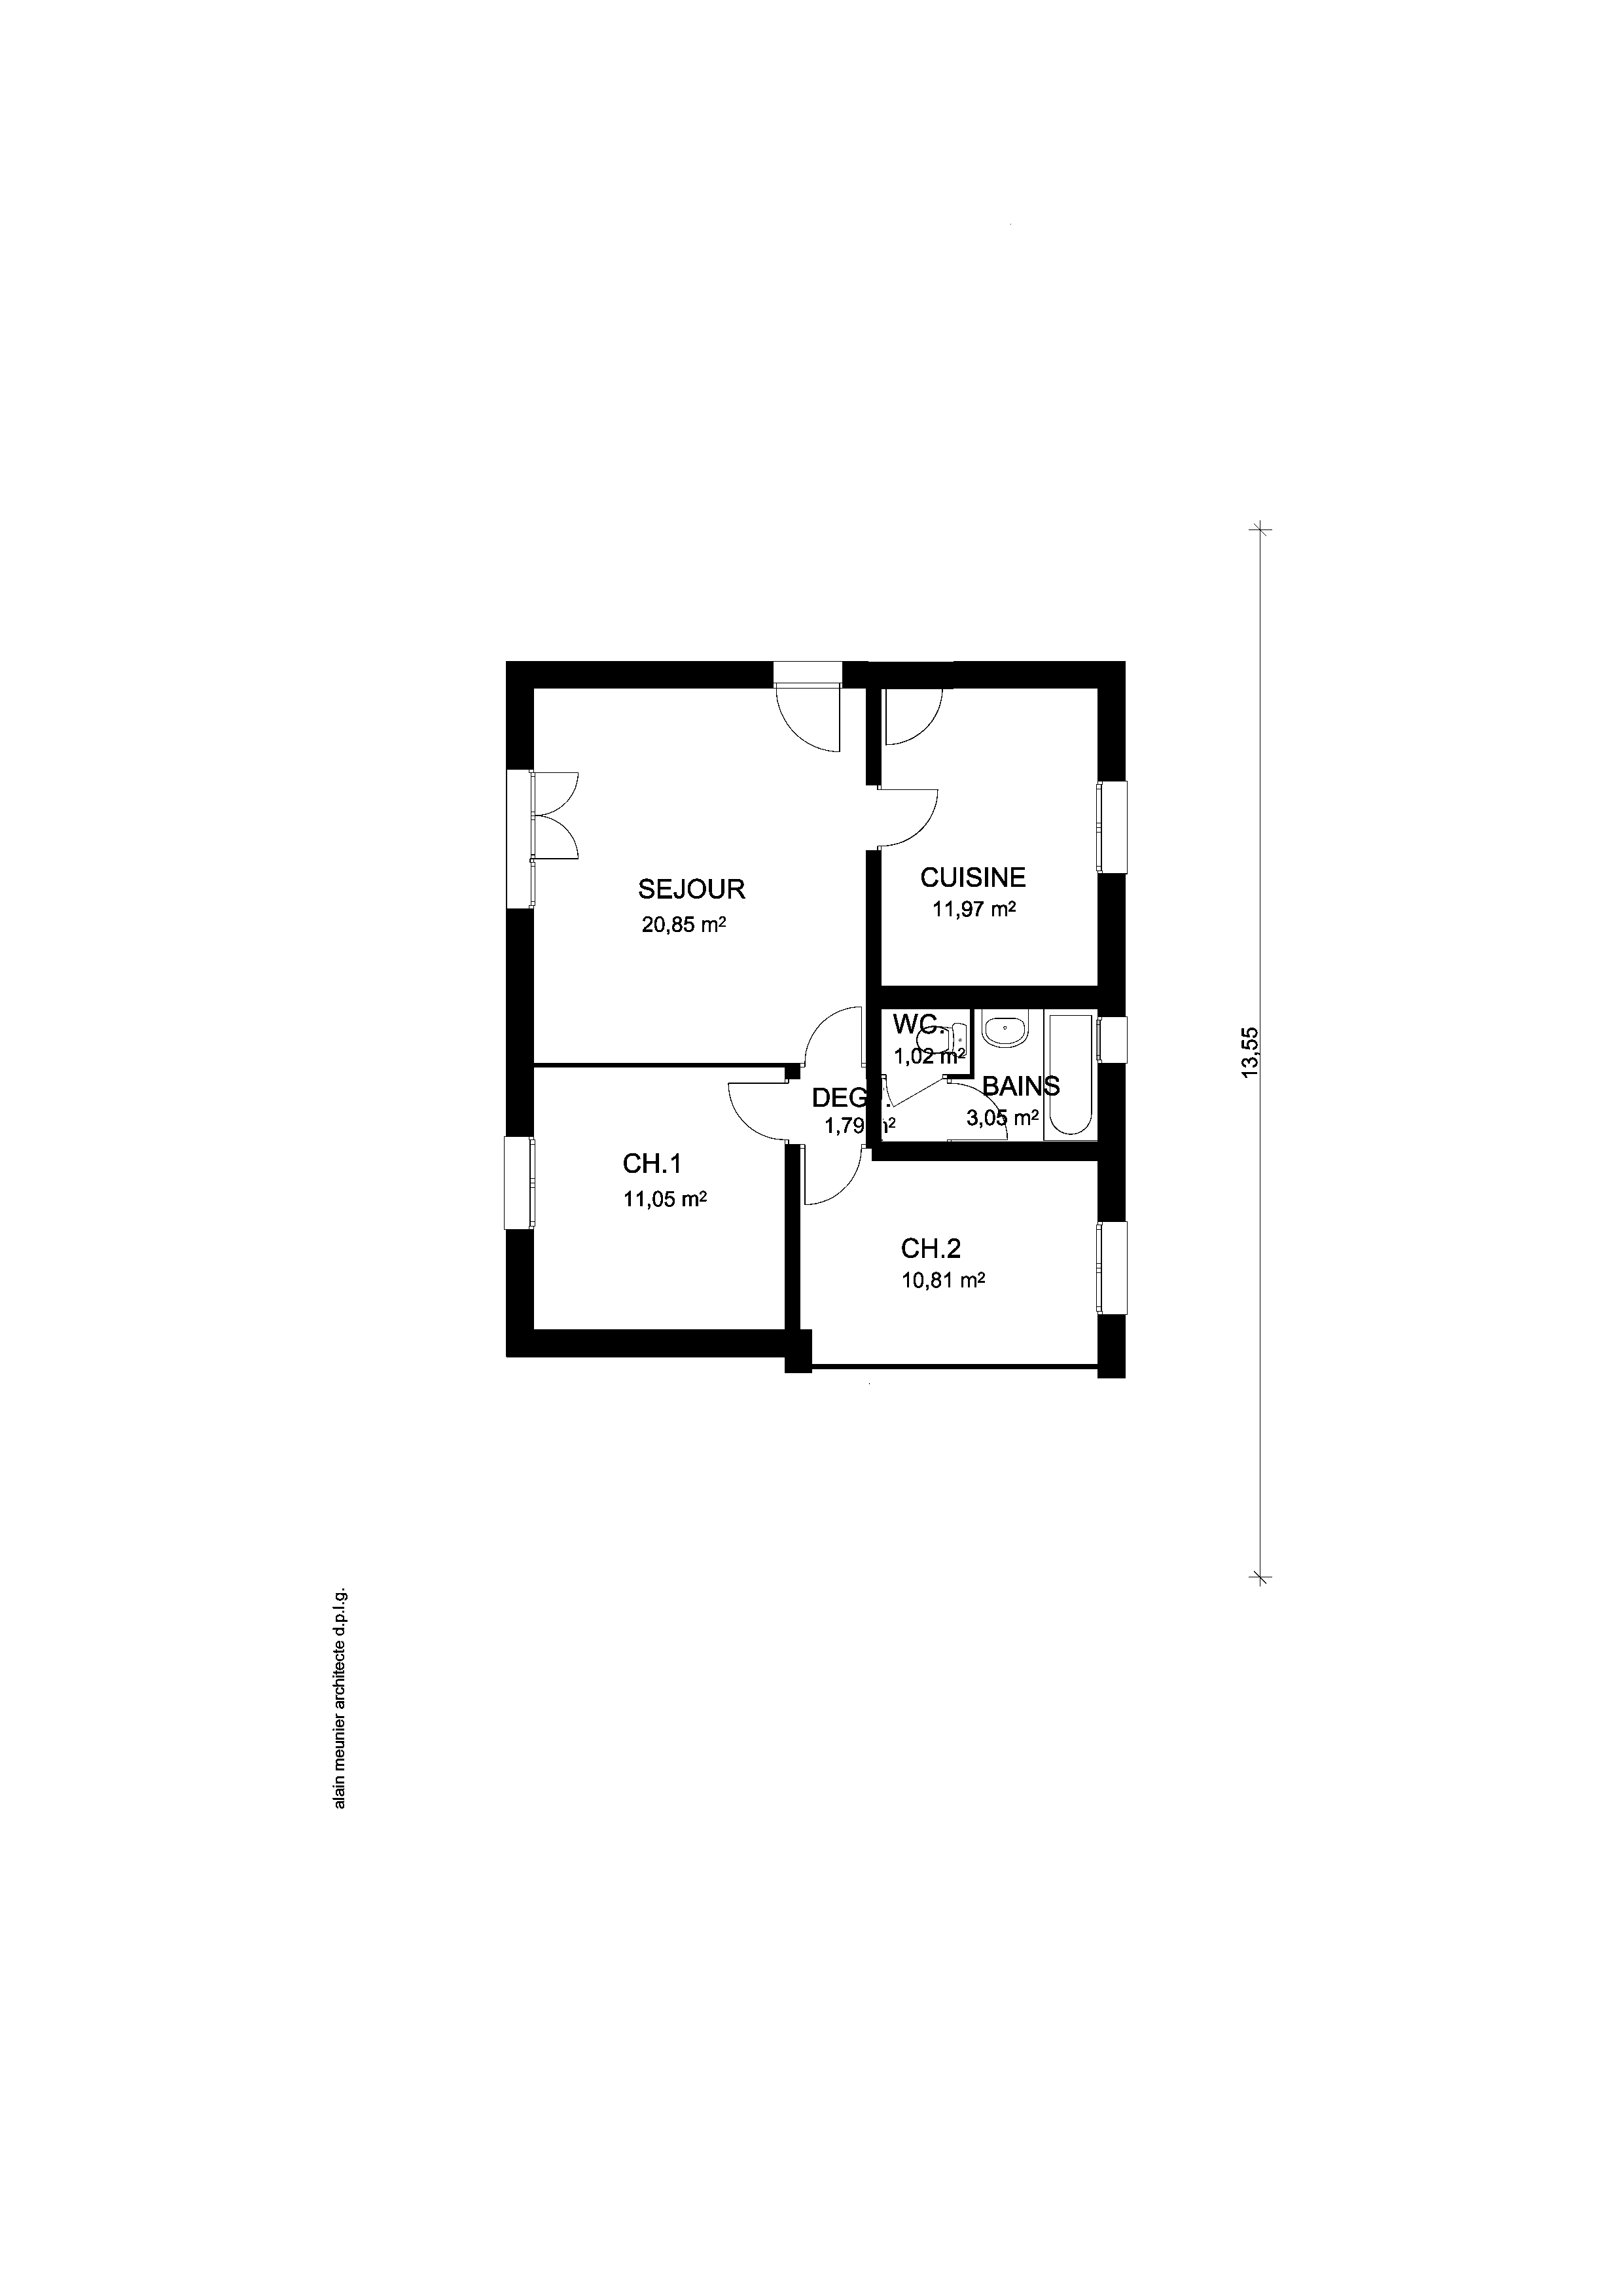

          xmin         ymin         xmax         ymax  confidence  class  name
0   736.107483   999.205078  1363.715454  1697.102295    0.718523      0  room
1  1236.850952  1735.666382  1691.190186  2098.622314    0.672907      0  room
2  1296.060425  1016.362244  1722.526733  1518.097656    0.615420      0  room
3  1303.186646  1512.497681  1697.362305  1779.351685    0.602618      0  room
4   787.302429  1575.287354  1240.267944  2074.597656    0.544000      0  room


In [45]:
# Displaying the co-ordinates of the bounding boxes
display(PIL.Image.open("test.png"))
bb_dataframe = result.pandas().xyxy[0]
print(bb_dataframe)
# for idx, row in bb_dataframe.iterrows():
#     rect = patches.Bbox([row['xmin'],row['ymin']],[row['xmax'],row['ymax']])
#     print(row['xmin'])

In [37]:
# # Extracting the classes with detected frequency
# import numpy as np
# co_ordinates = result.pred[0]
# print(co_ordinates.shape)
# new_points = []

# for rows in co_ordinates:
#     x_c = float((rows[0] + rows[2])/2)
#     y_c = float((rows[1] + rows[3])/2)
#     centroids = torch.tensor([x_c,y_c], device = "cuda")
#     rows = torch.cat((rows, centroids), 0)
#     new_points.append(rows)
# new_points = torch.stack(new_points)
# result.pred[0] = new_points


In [46]:
# percentage of overlap above which the rooms are considered neighbors
IOU = 0.2
# orthogonal overlap
offset = 200.0
# multiplication factor between pixels and image - empirically calculated for now
x_factor = 1.68*100
y_factor = 1.685*100
# factor of change in area
area_factor = x_factor* y_factor
# height assumed constant for the moment
height = 3.0 
# wll thickness - considered constant for the moment
thickness = 0.25
#volume to be calculated
volume = 0.0

# Numpy arraa of results from model
result_val = result.pred
# Name of elements in the image - room/windows/doors etc
entity_labels = []

# indices for elements
room_count = 0
window_count = 0
door_count = 0

# Graph for connectivity of room
connectivity = dict()

# Add element names to the labels 
for row in result_val[0]:
    if int(row[-1]) == 0:
        entity_labels.append("room"+str(room_count))
        room_count += 1
    elif int(row[-1]) == 1:
        entity_labels.append("window"+str(window_count))
        window_count += 1
    else:
        entity_labels.append("door"+str(door_count))
        door_count += 1
        
# reversing the list to make it consistent with detect.py results from the yolov5
entity_labels = list(reversed(entity_labels))

# setting attributes for each room 
for i in range(len(entity_labels)):
    connectivity[entity_labels[i]] = {"neighbors":[],"wall":[],"area":0.0, "thickness": 0.25, "volume":0.0}

# access the numpy array of results - result_val is a list with length 1 - the 0th element is the prediction
temp = result_val[0]
# array to store the centers of all bounding boxes - used later for labels
centers = []

# Finding connectivity and storing every connection with attributes of each room
for i in range(len(temp)):
    
    # coordinates of the bounding box of the single image to be matched against all others
    x1min, y1min, x1max, y1max = temp[i][0].item(), temp[i][1].item(), temp[i][2].item(), temp[i][3].item() 
    # centre of the bounding box
    x1c, y1c = (x1min+x1max)/2 , (y1min + y1max)/2
    # collecting centers of each bounding box
    if (x1c,y1c) not in centers:
        centers.append((x1c, y1c))
    # area and volume of the room to be matched
    area = ((x1max-x1min) * (y1max-y1min))/area_factor 
    volume = area * height
    connectivity[entity_labels[i]]["area"] = area
    connectivity[entity_labels[i]]["volume"] = volume
    # Comparing i th element with all others
    for j in range (len(temp)):
        if i!=j:
            x2min, y2min, x2max, y2max = temp[j][0].item(), temp[j][1].item(), temp[j][2].item(), temp[j][3].item()
            # x2c, y2c = (x2min+x2max)/2 , (y2min + y2max)/2  
            # check for neighbors and add only if it has not been added yet           
            if entity_labels[j] not in connectivity[entity_labels[i]]["neighbors"]:
                # check if the box i and j overlap on the "right" by offset amounts
                if abs(x1max - x2min)<=offset:
                    # standard iou technique - calculate overlap
                    overlap = abs(min(y1max,y2max) - max(y1min, y2min))
                    union = y1max - y1min + y2max - y2min - overlap
                    # the percentage of overlap is above IOU, consider it a true neighbor
                    intersection = overlap/union
                    #print("right", intersection)
                    if intersection>IOU:
                            connectivity[entity_labels[i]]["neighbors"].append(entity_labels[j])
                            connectivity[entity_labels[i]]["wall"].append(overlap/y_factor)
                # check for left neighbors
                if abs(x1min - x2max)<=offset:
                    overlap = abs(min(y1max,y2max) - max(y1min, y2min))
                    union = y1max - y1min + y2max - y2min - overlap
                    intersection = overlap/union
                    #print("left", intersection)
                    if intersection>IOU:
                            connectivity[entity_labels[i]]["neighbors"].append(entity_labels[j])
                            connectivity[entity_labels[i]]["wall"].append(overlap//y_factor)
                # check for top neighbors          
                if abs(y1max - y2min)<=offset:
                    overlap = abs(min(x1max,x2max) - max(x1min, x2min))
                    union = x1max - x1min + x2max - x2min - overlap
                    intersection = overlap/union 
                    #print("top", intersection)
                    if intersection>IOU:
                            connectivity[entity_labels[i]]["neighbors"].append(entity_labels[j])
                            connectivity[entity_labels[i]]["wall"].append(overlap/x_factor)
                # check for bottom neighbors
                if abs(y1min - y2max)<=offset:
                    overlap = abs(min(x1max,x2max) - max(x1min, x2min))
                    union = x1max - x1min + x2max - x2min - overlap
                    intersection = overlap/union
                    #print("bottom", intersection)
                    if intersection>IOU:   
                            connectivity[entity_labels[i]]["neighbors"].append(entity_labels[j])
                            connectivity[entity_labels[i]]["wall"].append(overlap/x_factor)
# Print connectivity and do a sanity check with the image
print(connectivity)

{'room4': {'neighbors': ['room2', 'room1', 'room0'], 'wall': [2.977658235000927, 1.0955763457436944, 2.6962233043852306], 'area': 15.472864785008328, 'thickness': 0.25, 'volume': 46.418594355024986}, 'room3': {'neighbors': ['room1', 'room0'], 'wall': [2.309544881184896, 2.0], 'area': 5.825389295701141, 'thickness': 0.25, 'volume': 17.476167887103422}, 'room2': {'neighbors': ['room4', 'room1'], 'wall': [2.0, 2.346283685593378], 'area': 7.558755450801348, 'thickness': 0.25, 'volume': 22.676266352404042}, 'room1': {'neighbors': ['room4', 'room3', 'room2', 'room0'], 'wall': [1.0, 2.309544881184896, 2.346283685593378, 1.0], 'area': 3.715817185759679, 'thickness': 0.25, 'volume': 11.147451557279037}, 'room0': {'neighbors': ['room4', 'room3', 'room1'], 'wall': [2.6962233043852306, 2.0114615692229227, 1.2110642792563056], 'area': 7.989626554018199, 'thickness': 0.25, 'volume': 23.968879662054597}}


Saved 1 image to .


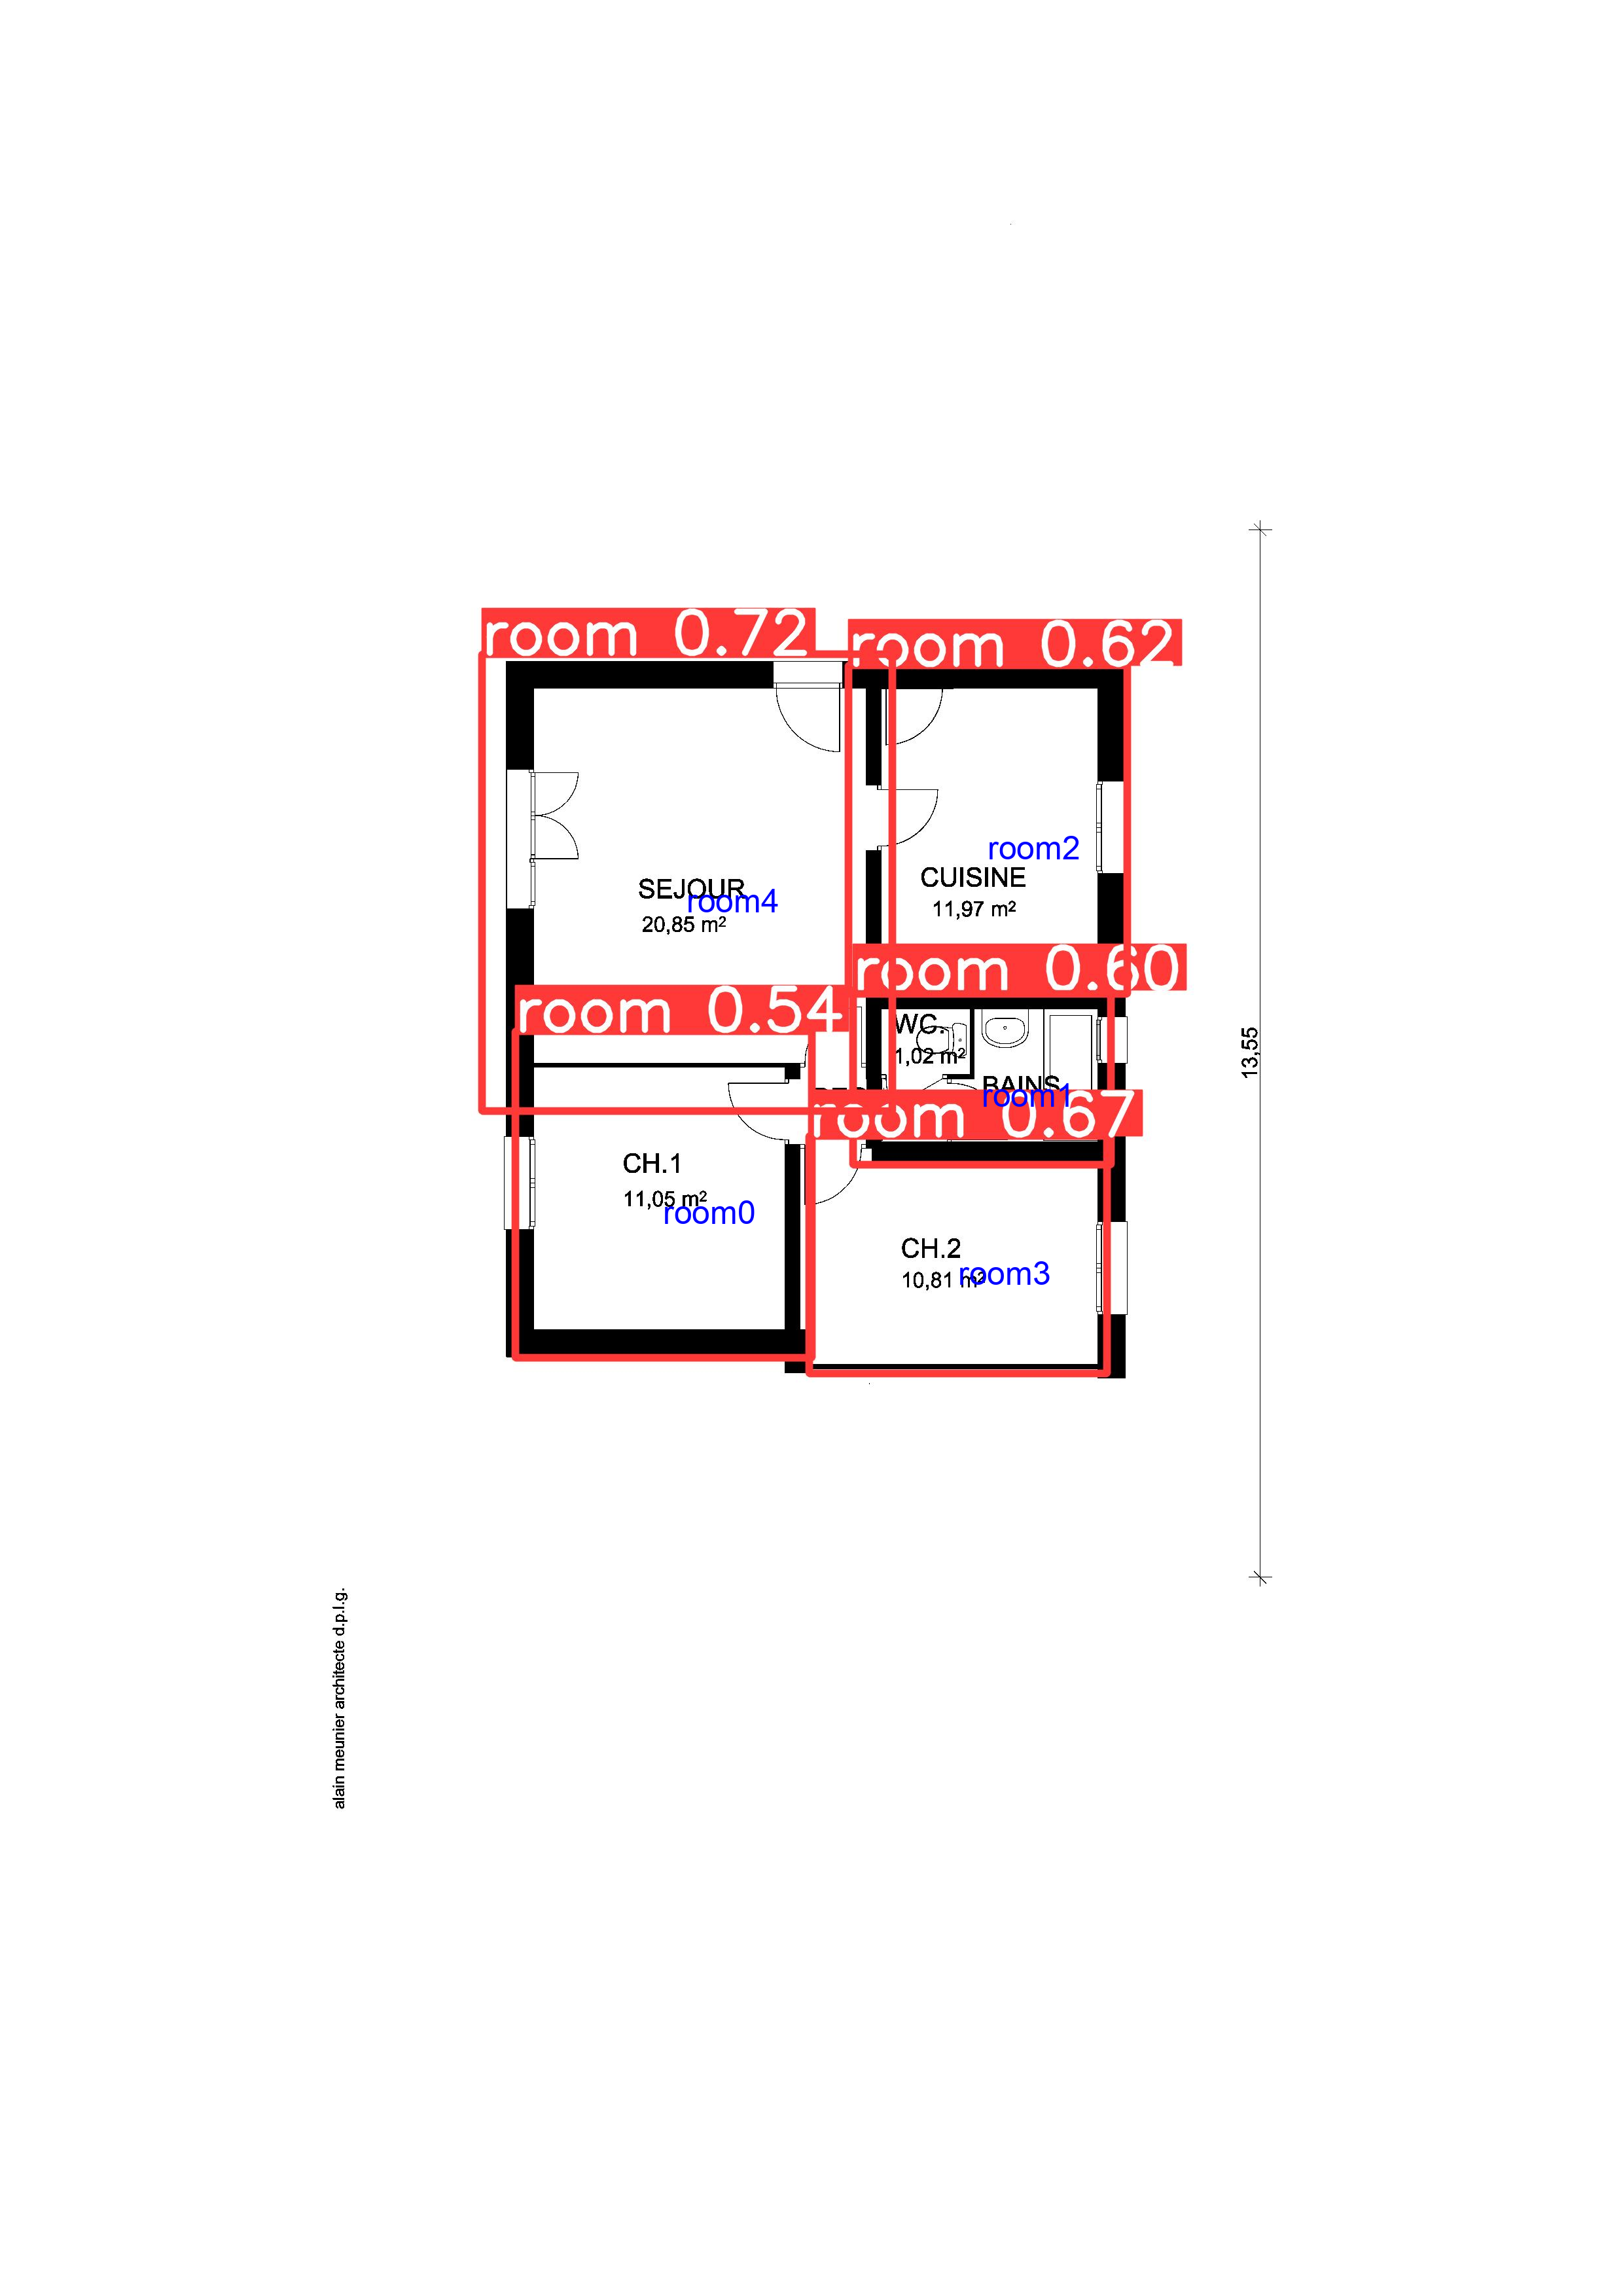

{'room4': {'neighbors': ['room2', 'room1', 'room0'], 'wall': [2.977658235000927, 1.0955763457436944, 2.6962233043852306], 'area': 15.472864785008328, 'thickness': 0.25, 'volume': 46.418594355024986}, 'room3': {'neighbors': ['room1', 'room0'], 'wall': [2.309544881184896, 2.0], 'area': 5.825389295701141, 'thickness': 0.25, 'volume': 17.476167887103422}, 'room2': {'neighbors': ['room4', 'room1'], 'wall': [2.0, 2.346283685593378], 'area': 7.558755450801348, 'thickness': 0.25, 'volume': 22.676266352404042}, 'room1': {'neighbors': ['room4', 'room3', 'room2', 'room0'], 'wall': [1.0, 2.309544881184896, 2.346283685593378, 1.0], 'area': 3.715817185759679, 'thickness': 0.25, 'volume': 11.147451557279037}, 'room0': {'neighbors': ['room4', 'room3', 'room1'], 'wall': [2.6962233043852306, 2.0114615692229227, 1.2110642792563056], 'area': 7.989626554018199, 'thickness': 0.25, 'volume': 23.968879662054597}}


In [47]:
# Rendering the image with bounding boxes
result.render(labels=True)
result.save(labels=True, save_dir=".")
image = PIL.Image.open("image0.jpg")
draw  = PIL.ImageDraw.Draw(image)
font  = PIL.ImageFont.truetype("arial.ttf", 50, encoding="unic")
for text, coordinates in zip(entity_labels, centers):
    # annotate each room and save with each annotation
    draw.text( (coordinates[0],coordinates[1]), text, font=font, fill="#0000FF")
    image.save("image0.png","png")
draw.text([1,5000],str(connectivity), font=font, fill="#0000FF")
image.save("image0.png","png")
display(PIL.Image.open("image0.png"))
print(connectivity)